# Email classification using Random forest trees and Linear Regression
In this project we will train a random forest algorithm and apply it a spambase dataset.

# Outline
- [ 0 - Problem description ](#0)
- [ 1 - Packages ](#1)
- [ 2 - Dataset ](#2)
- [ 3 - Loading data ](#3)
- [ 4 - RF Model ](#4)
- [ 5 - Logistic regression model ](#5)

<a name="0"></a>
## 0 - Problem description 

Spam email is unsolicited and unwanted junk email that is sent out in bulk to an indiscriminate recipient list. Typically, spam is sent for commercial purposes. It can be sent in massive volumes using botnets, networks of infected computers. Apart from commercial purposes, spam email is sent for malicious purposes as well such as money scams and phishing attacks. Although the context of a spam email can vary significantly, there are some keywords that most of them use. The challenge is to accurately identify these emails so they can be filtered out before reaching the user’s inbox.

## Dataset description

We will make use of the following dataset:  
Hopkins,Mark, Reeber,Erik, Forman,George, and Suermondt,Jaap. (1999). Spambase. UCI Machine Learning Repository. https://doi.org/10.24432/C53G6X.
This dataset contains 4601 instances which makes it suitable for our classification task as it meets the requirement of having more than 300 samples per class. Furthermore, it has a well-defined task, that is to classify emails as spam or non-spam.
This dataset contains:
- 48 continuous real [0,100] attributes of type word_freq_WORD 
= percentage of words in the e-mail that match WORD, i.e. 100 * (number of times the WORD appears in the e-mail) / total number of words in e-mail.  A "word" in this case is any string of alphanumeric characters bounded by non-alphanumeric characters or end-of-string.

- 6 continuous real [0,100] attributes of type char_freq_CHAR] 
= percentage of characters in the e-mail that match CHAR, i.e. 100 * (number of CHAR occurences) / total characters in e-mail

- 1 continuous real [1,...] attribute of type capital_run_length_average 
= average length of uninterrupted sequences of capital letters

- 1 continuous integer [1,...] attribute of type capital_run_length_longest 
= length of longest uninterrupted sequence of capital letters

- 1 continuous integer [1,...] attribute of type capital_run_length_total 
= sum of length of uninterrupted sequences of capital letters 
= total number of capital letters in the e-mail

- 1 nominal {0,1} class attribute of type spam
= denotes whether the e-mail was considered spam (1) or not (0), i.e. unsolicited commercial e-mail.  

According to the UCI repository this data set has some missing values, however, we couldn’t locate any after manually inspecting it.

## Method
We are planning to use a random forest classification algorithm that creates a “forest” of random decision trees using random subsets of the data and features. More specifically, each tree in the forest makes an independent prediction, and the class with the majority vote becomes the model's prediction. This algorithm is robust to overfitting due to the averaging of results and the randomness helps to make the model more diverse, thus increasing its accuracy.


<a name="1"></a>
## 1 - Packages 
 We will start by importing all the necessary packages for this project.
 - [scikit-learn](https://scikit-learn.org/stable/index.html) is a library used for the random forest implementation.
 - [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
 - [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.

In [40]:
#Data visualization
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

#Tree visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image

<a name="2"></a>
## 2 - Dataset
We will be working with the [spambase](https://archive.ics.uci.edu/dataset/94/spambase) dataset provided by the UCI machine learning repository. This dataset has 57 features and 1 target.
We start by checking the dataset for any missing values:

In [28]:
data_file_path = 'dataset/spambase_data'
names_file_path = 'dataset/column_names.txt'

with open(names_file_path, 'r') as file:
    column_names = [line.strip() for line in file if line.strip()]

column_names.append('is_spam')

data = pd.read_csv(data_file_path, header=None, names=column_names)

# Check for missing values
missing_values = data.isnull().sum()

# Print columns with missing values (if any)
columns_with_missing_values = missing_values[missing_values > 0]
print("\nColumns with missing values:")
print(columns_with_missing_values)


Columns with missing values:
Series([], dtype: int64)


As you can see, the dataset has no missing values. Thus, we can move on by checking the balance of the dataset:

In [5]:
# Check for balance
class_distribution = data['is_spam'].value_counts()
print("\nClass distribution in 'is_spam':")
print(class_distribution)

# Assessing the balance
total_samples = len(data)
balance_info = class_distribution / total_samples * 100
print("\nPercentage distribution:")
print(balance_info)


Class distribution in 'is_spam':
0    2788
1    1813
Name: is_spam, dtype: int64

Percentage distribution:
0    60.595523
1    39.404477
Name: is_spam, dtype: float64


From the code above, we can see that 60.60% of our emails are non-spam while the rest is spam (39.40%). While this dataset is not ideally balanced (50%-50% distribution) the difference is not so large as to cause significant concerns and the random forest should perform reasonably well. However we will keep an eye on the F1-Score to ensure that the model is performing well across both classes. If it is evident that the model is not performing as intended, we will balance the dataset and try again.

<a name="3"></a>
## 3 - Loading data
Next, we load the dataset in the variables X_train, X_test, y_train, y_test. We use a common 80% - 20% data split to train and evaluate the model.

In [6]:
#Split the data into features (X) and target (y)
def load_data(filename):
    data = np.loadtxt(filename, delimiter=',')
    X = data[:,:57]
    y = data[:,57]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data("dataset/spambase_data")

Lets get more familiar with our dataset by printing out the first five elements of each variable and see what it contains

In [7]:
#View variables
print("First five elements in X_train are:\n", X_train[:5])
print("Type of X_train:",type(X_train))
print("\n")

print("First five elements in y_train are:\n", y_train[:5])
print("Type of y_train:", type(y_train))
print("\n")

print("First five elements in X_test are:\n", X_test[:5])
print("Type of X_test:",type(X_test))
print("\n")

print("First five elements in y_test are:\n", y_test[:5])
print("Type of y_test:", type(y_test))

First five elements in X_train are:
 [[9.000e-02 0.000e+00 9.000e-02 0.000e+00 3.900e-01 9.000e-02 9.000e-02
  0.000e+00 1.900e-01 2.900e-01 3.900e-01 4.800e-01 0.000e+00 5.800e-01
  0.000e+00 8.700e-01 1.900e-01 0.000e+00 1.660e+00 4.100e+00 1.660e+00
  0.000e+00 3.900e-01 1.900e-01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  1.390e-01 0.000e+00 3.100e-01 1.550e-01 0.000e+00 6.813e+00 4.940e+02
  1.458e+03]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.580e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 7.900e-01 0.000e+00 7.900e-01
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.

Another usefull way to get familiar with the dataset is to view its dimensions:

In [8]:
#Check dimensions of train sample
print('The shape of X_train is:' + str(X_train.shape))
print('The shape of y_train is:' + str(y_train.shape))
print('We have m= %d training examples' % (len(y_train)))
print("\n")

#Check dimensions of test sample
print('The shape of X_test is:' + str(X_test.shape))
print('The shape of y_test is:' + str(y_test.shape))
print('We have m= %d training examples' % (len(y_test)))

The shape of X_train is:(3680, 57)
The shape of y_train is:(3680,)
We have m= 3680 training examples


The shape of X_test is:(921, 57)
The shape of y_test is:(921,)
We have m= 921 training examples


<a name="4"></a>
## 4 - RF Model
Now, we can start implementing the random forest tree. The random_state doesnt affect the performance of the model. It ensures that the randomness in the process is consistent across different runs:

In [29]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

Once the model is trained, we can check its performance by computing the accuracy and the classification report which gives information regarding:
- Accuracy : Indicates the number of times the RF model was successful on predicting if an email is spam or not.
- Precision : Indicates how accurate the predictions are.
- Recall : Reflects the model's ability to find all the relevant instances in the dataset

In [30]:
accuracy= accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print("Accuracy: ", accuracy)
print("Classification report: \n", classification_rep)


Accuracy:  0.9554831704668838
Classification report: 
               precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       531
         1.0       0.98      0.92      0.95       390

    accuracy                           0.96       921
   macro avg       0.96      0.95      0.95       921
weighted avg       0.96      0.96      0.96       921



Lets plot the F1-Score, since our dataset is a bit unbalanced, as well as the confusion matrix,to get a better idea of the performance of the model:

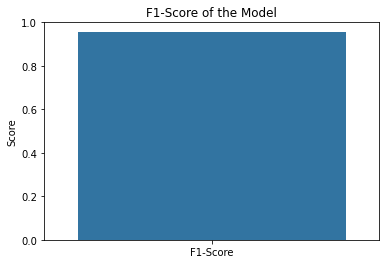

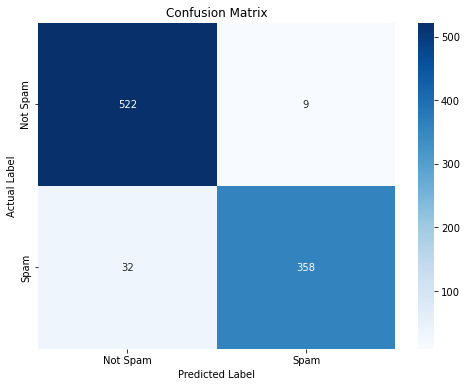

In [31]:
# Calculating F1-score
f1 = f1_score(y_test, y_pred, average='weighted')

# Plotting F1-score
plt.figure(figsize=(6, 4))
sns.barplot(x=['F1-Score'], y=[f1])
plt.ylim(0, 1)
plt.title('F1-Score of the Model')
plt.ylabel('Score')
plt.show()

# Calculating confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

The weighted average F1-score is approximately 0.955, which indicates that the model has a good balance between precision and recall for the dataset, taking into account the number of instances for each class.

The confusion matrix provides a breakdown of the true positives, false positives, true negatives, and false negatives:

- True Non-Spam Predictions: 522
- False Spam Predictions (Type I error): 9
- False Non-Spam Predictions (Type II error): 32
- True Spam Predictions: 358

The model has a higher number of false negatives (32) compared to false positives (9). This suggests that while the model is quite conservative in predicting spam (preferring to minimize false positives), it might be missing some actual spam emails (as indicated by the false negatives). 

Given the high performance metrics across the board, there doesn't seem to be a strong immediate need to balance the dataset further. Both classes are being predicted with high accuracy, precision, and recall, and the F1-scores are also strong. The slight imbalance in the dataset does not seem to be negatively impacting the model's ability to generalize.

<a name="5"></a>
## 5- LOGISTIC REGRESSION

sigmoid(0) = 0.5


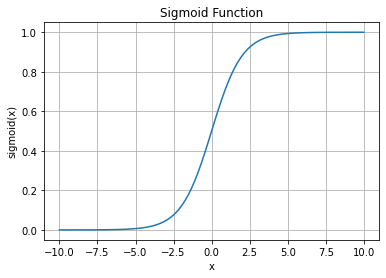

In [35]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z (ndarray): A scalar, numpy array of any size.

    Returns:
        g (ndarray): sigmoid(z), with the same shape as z
         
    """
          
    ### START CODE HERE ### 
    z = np.clip(z, -709, 709)  # np.exp(709) is close to the largest value representable by numpy float64
    g = 1 / (1 + np.exp(-z))
    g = np.clip(g, 1e-8, 1 - 1e-8)  # Clip the output to avoid extreme values
    ### END SOLUTION ###  
    
    return g

print ("sigmoid(0) = " + str(sigmoid(0)))
x = np.linspace(-10, 10, 100)

# Compute sigmoid values for x
y = sigmoid(x)

# Plot sigmoid function
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('sigmoid(x)')
plt.title('Sigmoid Function')
plt.grid(True)
plt.show()

In [36]:
# UNQ_C2
# GRADED FUNCTION: compute_cost
def compute_cost(X, y, w, b, lambda_= 1):
    """
    Computes the cost over all examples
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (array_like Shape (m,)) target value 
      w : (array_like Shape (n,)) Values of parameters of the model      
      b : scalar Values of bias parameter of the model
      lambda_: unused placeholder
    Returns:
      total_cost: (scalar)         cost 
    """
    m, n = X.shape
    ### START CODE HERE ###
    total_cost = 0
    prediction_model = sigmoid(np.dot(X,w)+b)
    loss_sum = (-1*y*np.log(prediction_model)) - (1 - y)*np.log(1-prediction_model)
    total_cost = np.sum(loss_sum)/m
    
    
    ### END CODE HERE ### 

    return total_cost

m, n = X_train.shape

# Compute and display cost with w initialized to zeroes
initial_w = np.zeros(n)
initial_b = 0.
cost = compute_cost(X_train, y_train, initial_w, initial_b)
print('Cost at initial w (zeros): {:.3f}'.format(cost))

Cost at initial w (zeros): 0.693


In [38]:
# UNQ_C3
# GRADED FUNCTION: compute_gradient
def compute_gradient(X, y, w, b, lambda_=None): 
    """
    Computes the gradient for logistic regression 
 
    Args:
      X : (ndarray Shape (m,n)) variable such as house size 
      y : (array_like Shape (m,1)) actual value 
      w : (array_like Shape (n,1)) values of parameters of the model      
      b : (scalar)                 value of parameter of the model 
      lambda_: unused placeholder.
    Returns
      dj_dw: (array_like Shape (n,1)) The gradient of the cost w.r.t. the parameters w. 
      dj_db: (scalar)                The gradient of the cost w.r.t. the parameter b. 
    """
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0

    # Prediction using current parameters
    prediction_model = sigmoid(np.dot(X, w) + b)

    # Compute gradients
    error = prediction_model - y
    dj_db = np.sum(error) / m
    dj_dw = np.dot(X.T, error) / m

    return dj_db, dj_dw
# Compute and display gradient with w initialized to zeroes
# initial_w = np.zeros(n)
# initial_b = 0.

# dj_db, dj_dw = compute_gradient(X_train, y_train, initial_w, initial_b)
# print(f'dj_db at initial w (zeros):{dj_db}' )
# print(f'dj_dw at initial w (zeros):{dj_dw.tolist()}' )

In [34]:
# Compute and display cost and gradient with non-zero w
# test_w = np.random.rand(X_train.shape[1])  # or any other method to create an array of length 57
# test_b = -24
# dj_db, dj_dw  = compute_gradient(X_train, y_train, test_w, test_b)

# print('dj_db at test_w:', dj_db)

# print('dj_dw at test_w:', dj_dw.tolist())

test_w = np.random.rand(X_train.shape[1], 1)  # Create a (n x 1) array of random weights
test_b = -24  # Set a test bias value

# Compute gradients
dj_db, dj_dw = compute_gradient(X_train, y_train, test_w, test_b)

# Print the results
print('dj_db at test_w:', dj_db)
# print('dj_dw at test_w:', dj_dw.tolist())

dj_db at test_w: 1691.700530300369


Iteration    0: Cost     7.12   
Iteration 10000: Cost     7.41   
Iteration 20000: Cost     6.49   
Iteration 30000: Cost     2.69   
Iteration 40000: Cost     5.29   
Iteration 50000: Cost     5.24   
Iteration 60000: Cost     2.57   
Iteration 70000: Cost     4.93   
Iteration 80000: Cost     4.54   
Iteration 90000: Cost     2.41   
Iteration 99999: Cost     2.40   


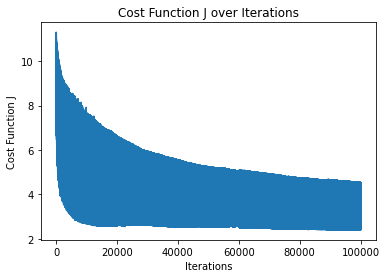

In [41]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X :    (array_like Shape (m, n)
      y :    (array_like Shape (m,))
      w_in : (array_like Shape (n,))  Initial values of parameters of the model
      b_in : (scalar)                 Initial value of parameter of the model
      cost_function:                  function to compute cost
      alpha : (float)                 Learning rate
      num_iters : (int)               number of iterations to run gradient descent
      lambda_ (scalar, float)         regularization constant
      
    Returns:
      w : (array_like Shape (n,)) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    
    # number of training examples
    m = len(X)
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
       
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

np.random.seed(1)
initial_w = np.random.rand(X_train.shape[1])  # or any other method to create an array of length 57
initial_b = 0


# Some gradient descent settings
iterations = 100000
alpha = 0.1

w,b, J_history,_ = gradient_descent(X_train ,y_train, initial_w, initial_b, 
                                   compute_cost, compute_gradient, alpha, iterations, 0)

# Assuming J_history is a list containing the cost at each iteration
plt.plot(J_history)
plt.title("Cost Function J over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Cost Function J")
plt.show()

We can see here the gradient descent in action. The more iterations the more the cost functions goes down

In [43]:
# UNQ_C4
# GRADED FUNCTION: predict

def predict(X, w, b): 
    """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w
    
    Args:
    X : (ndarray Shape (m, n))
    w : (array_like Shape (n,))      Parameters of the model
    b : (scalar, float)              Parameter of the model

    Returns:
    p: (ndarray (m,1))
        The predictions for X using a threshold at 0.5
    """
    # number of training examples
    m, n = X.shape   
    p = np.zeros(m)
   
    ### START CODE HERE ### 
    prediction_model = sigmoid(np.dot(X,w)+b)
    
    p[prediction_model>=0.5]=1
        
    ### END CODE HERE ### 
    return p
# Test your predict code
np.random.seed(1)
tmp_w = np.random.randn(2)
tmp_b = 0.3    
tmp_X = np.random.randn(4, 2) - 0.5

tmp_p = predict(tmp_X, tmp_w, tmp_b)
print(f'Output of predict: shape {tmp_p.shape}, value {tmp_p}')

Output of predict: shape (4,), value [0. 1. 1. 1.]


In [44]:
#Compute accuracy on our training set
p = predict(X_train, w,b)
print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))

Train Accuracy: 86.793478


Precision: 0.7935483870967742
F1 Score: 0.863157894736842


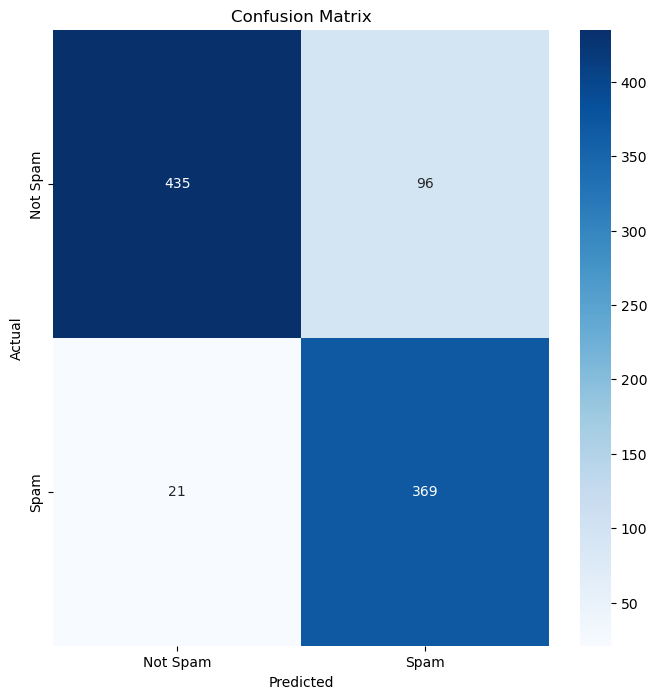

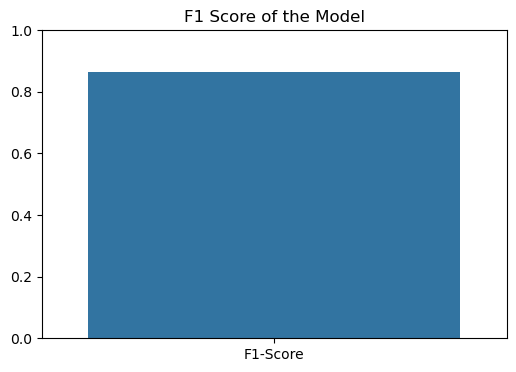

In [59]:
# Get predictions for the test set
probabilities = sigmoid(np.dot(X_test, w) + b)
predictions = probabilities >= 0.5  # apply threshold to get binary predictions

# Calculate the F1 score and precision
f1 = f1_score(y_test, predictions)
precision = precision_score(y_test, predictions)

# Print the precision and F1 score
print('Precision:', precision)
print('F1 Score:', f1)

# Generate and plot confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Plot F1-score
plt.figure(figsize=(6, 4))
sns.barplot(x=['F1-Score'], y=[f1])
plt.title('F1 Score of the Model')
plt.ylim(0, 1)
plt.show()

Classification Accuracy Insights:
    Correctly Identified 'Not Spam': 435 instances
    Correctly Identified 'Spam': 369 instances
    Misclassified 'Not Spam' as 'Spam': 96 instances (False Positives)
    Misclassified 'Spam' as 'Not Spam': 21 instances (False Negatives)

Effectiveness Metrics:
    Precision: 79.3% (Proportion of 'Spam' predictions that were correct)
    F1 Score: 86.4% (Balance between Precision and Recall)

The model is more prone to classify an email as 'Spam', which can be inferred from the higher number of False Positives.
The F1 Score indicates a robust performance with a good trade-off between Precision and Recall.
Adjustments may be necessary if the cost of False Positives is significant in the application context.

The Random Forest model shows superior performance with a higher F1-score and fewer misclassifications than the Logistic Regression model. It is more accurate in identifying both Spam and Not Spam, making it the better choice for this task.

# NOT FOR MILESTONE 1
We will try to tune the hyperparameters of the RF Model to check if the models performance can be improved:

In [85]:
param_dist = {'n_estimators': randint(50,500), 'max_depth': randint(1,20)}

rf=RandomForestClassifier(random_state=42)

rand_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter=5, cv=5, random_state=42, scoring='accuracy')

rand_search.fit(X_train,y_train)

best_rf = rand_search.best_estimator_

print("Best hyperparameters:", best_rf)

Best hyperparameters: RandomForestClassifier(max_depth=19, n_estimators=264, random_state=42)


Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.96       531
         1.0       0.97      0.92      0.94       390

    accuracy                           0.95       921
   macro avg       0.96      0.95      0.95       921
weighted avg       0.95      0.95      0.95       921

Accuracy: 0.9543973941368078


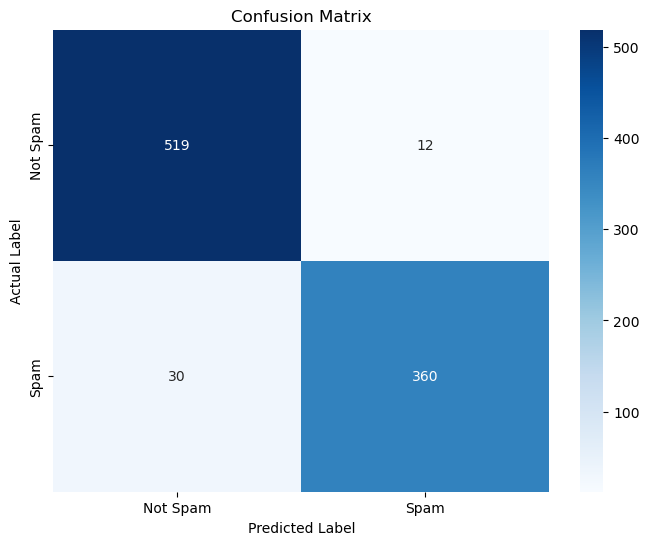

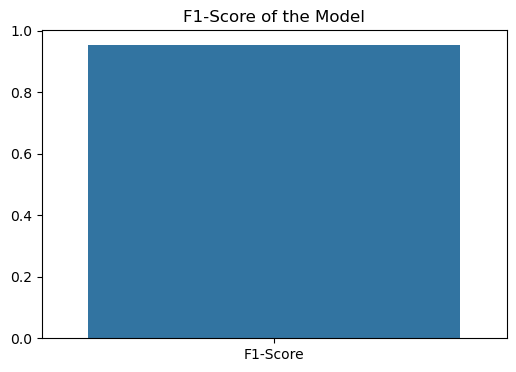

In [86]:

# Assuming rand_search has been fitted and best_rf has been identified
# Predict on the test set using the best estimator
y_pred = best_rf.predict(X_test)

# Calculate the F1 score (weighted, because of class imbalance)
f1 = f1_score(y_test, y_pred, average='weighted')

# Calculate the overall accuracy
accuracy = accuracy_score(y_test, y_pred)

# Generate the classification report
class_report = classification_report(y_test, y_pred)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the classification report and accuracy
print("Classification Report:\n", class_report)
print("Accuracy:", accuracy)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot the F1-score
plt.figure(figsize=(6, 4))
sns.barplot(x=['F1-Score'], y=[f1])
plt.title('F1-Score of the Model')
plt.show()
